<a href="https://colab.research.google.com/github/amita-kapoor/Designing-Models-for-Responsible-AI/blob/main/Chapter9/DoWhy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install dowhy

In [ ]:
import dowhy
import dowhy.datasets
from dowhy import CausalModel

In [ ]:
# Generate data
data = dowhy.datasets.linear_dataset(beta=10,
        num_common_causes=5,
        num_instruments = 2,
        num_effect_modifiers=2,
        num_samples=6000, 
        treatment_is_binary=True,
        stddev_treatment_noise=9,
        num_discrete_common_causes=1)
df = data["df"]

In [ ]:
data

{'df':             X0        X1   Z0        Z1        W0        W1        W2  \
 0    -1.724212  2.300134  0.0  0.966130  1.945950  0.072680  0.858006   
 1    -0.463515  0.390642  0.0  0.777092  1.292765  0.202232 -0.768118   
 2    -0.959155  0.424780  0.0  0.226372  0.820539 -0.064837  0.222957   
 3     0.226431 -1.599722  0.0  0.351051 -0.094378 -0.838482  0.518078   
 4    -1.677042  0.270265  0.0  0.663798  0.640499  0.070044 -0.497606   
 ...        ...       ...  ...       ...       ...       ...       ...   
 5995 -0.144817  0.425287  0.0  0.118599  2.702534 -0.295581  0.778611   
 5996 -1.189348  0.304257  0.0  0.974138  1.017732  0.039017  1.360681   
 5997 -0.295858 -0.084796  0.0  0.209793 -0.033295 -1.980476  0.219507   
 5998  0.024590 -0.440445  0.0  0.840843 -0.095737  1.719022  1.189504   
 5999  0.720846  1.087461  0.0  0.060918  0.476511  0.122529  0.914968   
 
             W3 W4    v0          y  
 0     1.736059  0  True  33.722203  
 1     1.877298  3  True  28

In [ ]:
# Input a causal graph in GML format
model=CausalModel(
        data = df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        graph=data["gml_graph"]
        )

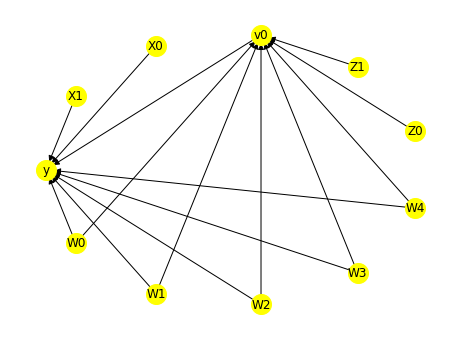

In [ ]:
model.view_model()

In [ ]:
# Identification
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W3,W1,W2,W4])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W1,W2,W4,U) = P(y|v0,W0,W3,W1,W2,W4)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [ ]:
# Estimation
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W3,W1,W2,W4])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W1,W2,W4,U) = P(y|v0,W0,W3,W1,W2,W4)

## Realized estimand
b: y~v0+W0+W3+W1+W2+W4
Target units: ate

## Estimate
Mean value: 9.653019195504354



In [ ]:
# Causal effect on the control group (ATC)
causal_estimate_att = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification",
        target_units = "atc")
print(causal_estimate_att)
print("Causal Estimate is " + str(causal_estimate_att.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W3,W1,W2,W4])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W3,W1,W2,W4,U) = P(y|v0,W0,W3,W1,W2,W4)

## Realized estimand
b: y~v0+W0+W3+W1+W2+W4
Target units: atc

## Estimate
Mean value: 9.635693131427233

Causal Estimate is 9.635693131427233


In [ ]:
# III. Estimate the target estimand using a statistical method.
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_matching")

In [ ]:
# adding random common cause variable
res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause", show_progress_bar=True)
print(res_random)

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

Refute: Add a random common cause
Estimated effect:8.258162442940941
New effect:8.258162442940941
p value:2.0



In [ ]:
# Replacing treatment with a placebo variable
res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", show_progress_bar=True, placebo_type="permute")
print(res_placebo)

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

Refute: Use a Placebo Treatment
Estimated effect:8.258162442940941
New effect:-0.014543074220012504
p value:0.98



In [ ]:
# Removing random subst of data
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", show_progress_bar=True, subset_fraction=0.9)
print(res_subset)

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

Refute: Use a subset of data
Estimated effect:8.258162442940941
New effect:8.340637008800014
p value:0.8600000000000001

